<h1>Achiziția și analiza datelor dependente de timp (Time-series)</h1>


<b>DESCRIERE PROIECT</b>

    Acest proiect are ca si scop realizarea unor reprezentari de tip Time-Series cu ajutorul limbajului de programare Python si a bazei de date InfluxDB.
    In cadrul proiectului se va regasi scrierea datelor din mai multe fisiere CSV in baza de date, realizarea reprezentarii pe harta a antenelor cu ajutorul unui fisier geojson care prezinta coordonatele geografice a acestra, dar si realizarea unor rapoarte care pot reprezenta situatii ipotetice.

<h3>PASUL 1:</h3><b>IMPORTAREA BIBLIOTECILOR NECESARE</b>

Pentru a putea realiza diferite actiuni vom avea nevoie de biblioteci care prezinta niste functii predefinite. Aceste functii predefinite ne pot ajuta, spre exempu, la scrierea datelor, la preluarea valorilor din cadrul csv-urilor, la conectarea cu cluentul bazei de date, la preluarea datelor din cadrul fisierului geojson etc.

In [62]:
from asyncore import read
from cgi import print_form
from importlib.resources import path
from logging import shutdown
from multiprocessing.connection import wait
from nturl2path import pathname2url
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.write_api import SYNCHRONOUS
import glob
import os
from numpy import equal
import pandas as pd
import json
import geojson
import csv
from pandas.io.json import json_normalize
import influxdb_client
import matplotlib
from statsmodels.tsa.api import Holt
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

<h3>PASUL 2:</h3><b>REALIZAREA CONEXIUNI CU INFLUXDB</b>

Pentru a putea scrie datele in cadrul bazei de date ne sunt necesare detaliile clientului din InfluxDB. Astfel folosim numele organizatiei, al bucket-ului in care vor fi adaugare datele, url-ul care reprezinta host-ul local (cel care este standard de baza de date), dar si API token-ul, care este unic pentru fiecare client al bazei de date. 

In [63]:
# Realizarea conexiunii cu InfluxDB
token = "G6D1pD2v4wsQSCjgUEtJYZA_myiaQUdIJLS7D7LhJVhIJyta-G7ip7iUi2PlZ-yP_EtjC8gWyy00xyKbgKs0qA=="
org = "Licenta-UPT"
bucket = "Licenta"
url = "http://localhost:8086"

    Ulterior vom crea instanta pentru client cu ajutorul datelor deja precizate in variabilele de mai sus:

In [64]:
# Instanta client
client = InfluxDBClient(url=url, token=token, org=org, debug=False)

<h3>PASUL 3:</h3><b>SCRIEREA DATELOR IN INFLUXDB</b>

Pentru a se realiza scrierea in InfluxDB vom folosi functia de scriere "write", fiind necesar sa precizam la inceput valorile parametrilor functiei. Acesti parametrii specificati ne ajuta la scrierea datelor in mod corect:

In [65]:
# Instanta scriere
write_api = client.write_api(write_options=WriteOptions(batch_size=80_000, flush_interval=10_000, jitter_interval=2_000, retry_interval=5_000))

Datele noastre sunt formate din CSV-uri cu SMS-uri primate, SMS-uri trimise, apeluri primite, apeluri effectuate, activitate pe internet, astfel am realizat doua functii care vor realiza scrierea datelor in baza de date, deoarece coloanele sunt diferite in cele doua calupuri de fisiere (call si sms). 
    
Fiecare functie prezinta calea catre dosarul cu toate fisierele care apoi sunt verificate sa fie cu extensia de ".csv", iar daca acestea au extensia dorita se vor lua coloanele dorite din interiorul fisierelor.

In cadrul folderului cu datele avem si un fisier GEOJSON in care se afla coordonatele celulelor antenelor care prelucreaza interactiunile dorite de catre utilizator. Aceste date sunt de tip poligon, astfel se poate realiza forma celulei.

In InfluxDB nu se poate realiza decat localizarea de tip "Point", deci sa fie doar un punct pe harta unde se afla celula respectiva. Astfel, vom scoate doar primele datele de latitudine si logitudine din cadrul fisierului GEOJSON, iar acest lucru il cealizam cu ajutorul functiei 'lambda', care va parcurge toate campurile fisierului si ne va extrage doar cele doua componente de geolocatie.

In urma extrageri latitudinii si longitudinii le vom alatura tabelului deja existent cu ajutorul functiei 'merge'.
    Se creeaza un index pentru date, in functie de coloana de timp ("datetime") si se vor scrie datele in interiorul masuratorii create.

In [66]:
# Scrierea datelor in InfluxDB
def f_call():
    path = 'D:\Facultate\Licenta\Date\Test\call'
    files = glob.glob(path + "/*.csv")
    for filename in files:
        df = pd.read_csv(filename, index_col=None)
        # Pregatirea datelor
        fields = ['datetime', 'CellID', 'provinceName', 'cell2Province', 'Province2cell'] 
        datatags = ['provinceName']
        # Pastrarea coloanele de interes
        df = df[fields]
        # Geolocatie - coordonate geojson
    with open("D:\Facultate\Licenta\Date\Test\milano-grid.geojson", "r") as pathX:
        data = json.load(pathX)
        df1 = pd.DataFrame(data["features"])
        df1['cellId'] = df1['properties'].apply(lambda x: x['cellId'])
        df1['lat'] = df1['geometry'].apply(lambda x: x['coordinates'][0][0][1])
        df1['lon'] = df1['geometry'].apply(lambda x: x['coordinates'][0][0][0])
        df1 = df1.drop(['type', 'id', 'geometry', 'properties'], axis=1)
    df2 = pd.merge(df, df1, left_on= 'CellID', right_on= 'cellId') 
    df2 = df2.drop(['cellId'], axis=1)
    print(df2)
    #Indexare
    df.set_index('datetime',inplace=True)
    #Scriere
    # write_api.write(bucket, record=df2, data_frame_measurement_name='Date_9', data_frame_tag_columns=datatags)

Pentru datele din cel de-al doilea fisier apare o singura schimbare in codul de incarcare al datelor. Datele din tabele prezinta o coloana de 'contrycode', prin care ne este greu sa identificam tara cu datele aferente, prin urmare am creat un tabel separat cu numele tarilor in funtie de numarul acestora:

In [67]:
def f_sms():
    path = 'D:\Facultate\Licenta\Date\Test\sms'
    files = glob.glob(path + "/*.csv")
    #Inlocuire 'CountryCode' cu 'CountryName' in fisierele sms 
    for filename in files:
        df = pd.read_csv(filename, index_col=None)
        fields = ['datetime', 'CellID', 'countrycode', 'smsin', 'smsout', 'callin', 'callout', 'internet'] 
        df = df[fields]
        df1 = pd.read_csv('D:\Facultate\Licenta\Date\Test\CountryCode.csv')
        df2 = pd.merge(df, df1, on='countrycode')
        # print(df2)
        fields1 = ['datetime', 'CellID', 'CountryName', 'smsin', 'smsout', 'callin', 'callout', 'internet']
        datatags1 = ['CountryName']
        df2 = df2[fields1]
    # Geolocatie - coordonate geojson
    with open("D:\Facultate\Licenta\Date\Test\milano-grid.geojson", "r") as pathX:
        data = json.load(pathX)
        df3 = pd.DataFrame(data["features"])
        df3['cellId'] = df3['properties'].apply(lambda x: x['cellId'])
        df3['lat'] = df3['geometry'].apply(lambda x: x['coordinates'][0][0][1])
        df3['lon'] = df3['geometry'].apply(lambda x: x['coordinates'][0][0][0])
        df3 = df3.drop(['type', 'id', 'geometry', 'properties'], axis=1)
    df4 = pd.merge(df2, df3, left_on= 'CellID', right_on= 'cellId') 
    df4 = df4.drop(['cellId'], axis=1)
    print(df4)
    df4.set_index('datetime',inplace=True)
    write_api.write(bucket, record=df4, data_frame_measurement_name='Date_9', data_frame_tag_columns=datatags1)

<h3>PASUL 4:</h3><b>Interogarea datelor</b>

Pentru a putea interoga datele dorite din baza de date vom realiza o functie care preia codul scris in Flux si il va scrie in baza de date:

In [68]:
#Query
def query_1():
    query_api = client.query_api()
    query = 'from(bucket: "Licenta")\
    |> range(start: 2013-11-01, stop: 2013-11-02)\
    |> filter(fn: (r) => r._measurement == "Date_9")\
    |> filter(fn: (r) => r._field == "internet")\
    |> filter(fn: (r) => r.CountryName == "Italy" )\
    |> limit(n:20)\
    |> keep(columns:["_time", "_value"])' 

    final_df = client.query_api().query_data_frame(org=org, query=query)
    final_df["_time"] = pd.to_datetime(final_df["_time"].astype(str))
    final_df = final_df.drop(columns=["result", "table"])
    final_df = final_df.set_index("_time")
    # print(final_df)
    final_df.plot()

<h3>PASUL 5:</h3><b>Estimarea datelor</b>

Pentru a putea realiza estimari de date, ca prim pas trebuie sa realizez o interogare care mai apoi o voi face un dataframe. Toate datele din dataframe vor fi pregatite, astfel voi seta ca index timpul, iar ulterior voi pastra doar indexum si valorile aferente acestuia.
Pentru a realiza vizualizarea propriu-zisa a trebuit sa creez o fereastra de dimenziuni: 10 latime si 8 inaltime, cu luniile principale de culoare neagra si verde, iar estimarea este de culoare rosie pentru a putea fi usor diferentiata fata de ceellalte doua linii.
Toate aceste date vor rezulta in final un grafic care ne arata traficul de internet din Italia intr-o zi si cum va evolua el in dimineata urmatoare urmatoare.

In [69]:
def prognozare():
    # Interogarea datelor
    query = 'from(bucket: "Licenta") \
    |> range(start: 2013-11-01, stop: 2013-11-02) \
    |> filter(fn: (r) => r._measurement == "Date_9") \
    |> filter(fn: (r) => r.CountryName == "Italy") \
    |> filter(fn: (r) => r._field == "internet")'
    # Query dataframe
    df = client.query_api().query_data_frame(org=org, query=query)
    #Pregatirea datelor
    df_holt = df.set_index("_time") # setare index
    df2 = df_holt.iloc[:,4] # pastrarea indexului si valorilor

    df3 = Holt(df2,damped_trend=True,initialization_method="estimated").fit(optimized=True)
    df4 = df3.forecast(10).rename("Prognozarea in timp")
    # Caracteristicile vizualizarii
    plt.figure(figsize=(10, 8))
    plt.plot(df_holt["_value"], marker='o', color='black')
    plt.plot(df3.fittedvalues, color='green')
    line1, = plt.plot(df4, marker='o', color='red')
    plt.legend([line1], [df4.name])

In [70]:
def locatie():
    path = 'D:\Facultate\Licenta\Date\Test\sms'
    files = glob.glob(path + "/*.csv")
    for filename in files:
        df = pd.read_csv(filename, index_col=None)
        fields = ['CellID','internet'] 
        df = df[fields]
        df4 = df.groupby('CellID')["internet"].sum() 

        with open("D:\Facultate\Licenta\Date\Test\milano-grid.geojson", "r") as pathX:
            data = json.load(pathX)
            df3 = pd.DataFrame(data["features"])
            df3['cellId'] = df3['properties'].apply(lambda x: x['cellId'])
            df3['lat'] = df3['geometry'].apply(lambda x: x['coordinates'][0][0][1])
            df3['lon'] = df3['geometry'].apply(lambda x: x['coordinates'][0][0][0])
            df3 = df3.drop(['type', 'id', 'geometry', 'properties'], axis=1)
        df2 = pd.merge(df4, df3, left_on= 'CellID', right_on= 'cellId')

    fig = px.scatter_mapbox(df2, lat="lat", lon="lon", hover_data=["cellId"], 
                                color = 'internet', zoom=12, height=500, 
                                mapbox_style = "carto-positron") 
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

<h3>PASUL 6:</h3><b>Verificare pentru rulare</b>

Pentru a nu ne incurca cu functiile pe care le realizam in cadrul programului am realizat o verificare pentru acestea. Acest lucru se realizeaza cu ajutorul lui if, care realizeaza rularea funtiilor care sunt de tip '__main__':

c:\Users\Lavinia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



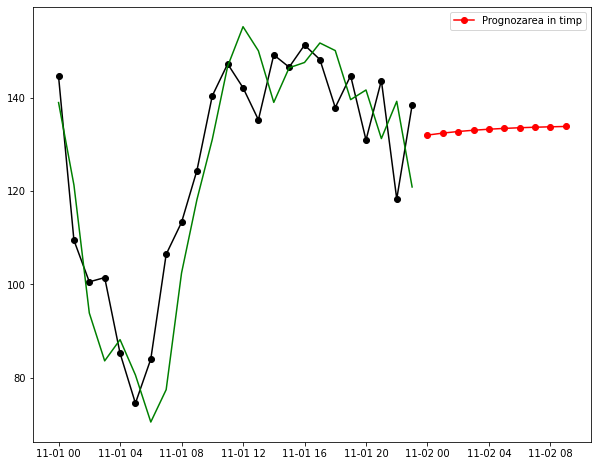

In [71]:
if __name__ == "__main__":
    # f_call()
    # f_sms()
    # query_1()
    prognozare()
    # locatie()